#NLP Semtiment & Emotion Classification System

In [2]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [3]:
# Load the emotion dataset - Contains 6 emotions
df = load_dataset("dair-ai/emotion")

print("Dataset loaded successfully!")
print(f"Train samples: {len(df['train'])}")
print(f"Validation samples: {len(df['validation'])}")
print(f"Test samples: {len(df['test'])}")

Dataset loaded successfully!
Train samples: 16000
Validation samples: 2000
Test samples: 2000


In [4]:
# Define Tokenizer - DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_text(texts, max_length=128):
    """
    Tokenize texts with padding and truncation
    """
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

print("Tokenizer loaded successfully!")

Tokenizer loaded successfully!


In [5]:
# Prepare TRAINING data
encoded_train = tokenize_text(list(df['train']['text']))
train_input_ids = encoded_train['input_ids']
train_attention_mask = encoded_train['attention_mask']
train_labels = tf.constant(list(df['train']['label']), dtype=tf.int32)

# Prepare VALIDATION data
encoded_val = tokenize_text(list(df['validation']['text']))
val_input_ids = encoded_val['input_ids']
val_attention_mask = encoded_val['attention_mask']
val_labels = tf.constant(list(df['validation']['label']), dtype=tf.int32)

# Compute class weights automatically
train_labels_list = list(df['train']['label'])

#Formula: weight = total_samples / (n_classes × samples_in_class)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_list),
    y=train_labels_list
)

class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class weights computed:")
emotion_names = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}
for label, weight in class_weights.items():
    print(f"  {emotion_names[label]}: {weight:.4f}")

# Create datasets with smaller batch size
BATCH_SIZE = 16

# Create TRAINING dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_ids": train_input_ids,
            "attention_mask": train_attention_mask,
        },
        train_labels
    )
)
train_dataset = train_dataset.shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Create VALIDATION dataset
val_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_ids": val_input_ids,
            "attention_mask": val_attention_mask,
        },
        val_labels
    )
)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"\nTraining dataset created with batch size: {BATCH_SIZE}")
print(f"Validation dataset created")

Class weights computed:
  Sadness: 0.5715
  Joy: 0.4973
  Love: 2.0450
  Anger: 1.2351
  Fear: 1.3767
  Surprise: 4.6620

Training dataset created with batch size: 16
Validation dataset created


In [6]:
# Load pre-trained DistilBERT model
bert_model = TFAutoModel.from_pretrained(
    "distilbert-base-uncased",
    use_safetensors=False,
    return_dict=False
)

# Enable fine-tuning
bert_model.trainable = True

print("BERT model loaded!")


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


BERT model loaded!


In [ ]:
class ImprovedBertClassifier(tf.keras.Model):
    def __init__(self, bert_model, num_classes=6):
        super().__init__()
        self.bert = bert_model
        self.dropout1 = tf.keras.layers.Dropout(0.4)
        self.dense = tf.keras.layers.Dense(256, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(0.3)
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs, training=False):
        # Pass through BERT
        bert_outputs = self.bert(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            training=training
        )

        # Mean pooling with attention mask
        token_embeddings = bert_outputs[0]
        attention_mask = tf.cast(inputs["attention_mask"], tf.float32)
        mask = tf.expand_dims(attention_mask, axis=-1)
        masked_embeddings = token_embeddings * mask

        # Keep the dimension correct
        sum_embeddings = tf.reduce_sum(masked_embeddings, axis=1)
        sum_mask = tf.reduce_sum(mask, axis=1)
        mean_pool = sum_embeddings / tf.maximum(sum_mask, 1e-9)  # Avoid division by zero

        # Pass through classification head
        x = self.dropout1(mean_pool, training=training)
        x = self.dense(x)
        x = self.dropout2(x, training=training)
        return self.classifier(x)

print("Model architecture defined!")

Model architecture defined!


In [ ]:
# Build the improved model
model = ImprovedBertClassifier(bert_model)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Build model by passing dummy data
dummy_input = tokenizer("test", return_tensors="tf", padding=True)
_ = model(dummy_input)

print("Model compiled successfully!")


Model compiled successfully!


In [9]:
callbacks = [
    # Early stopping to prevent overfitting
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when validation loss plateaus
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best model
    tf.keras.callbacks.ModelCheckpoint(
        'best_emotion_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

print("Callbacks configured!")

Callbacks configured!


In [10]:
print("Starting training with improvements...")

# TRAIN THE MODEL
history = model.fit(
    train_dataset,              # Use train_dataset
    validation_data=val_dataset,  # Use val_dataset
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Starting training with improvements...
Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 0.6300 - accuracy: 0.7563
Epoch 1: val_accuracy improved from -inf to 0.92250, saving model to best_emotion_model.h5
1000/1000 [==============================] - 207s 171ms/step - loss: 0.6300 - accuracy: 0.7563 - val_loss: 0.2204 - val_accuracy: 0.9225 - lr: 2.0000e-05
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.9255
Epoch 2: val_accuracy improved from 0.92250 to 0.92650, saving model to best_emotion_model.h5
1000/1000 [==============================] - 155s 155ms/step - loss: 0.1958 - accuracy: 0.9255 - val_loss: 0.1884 - val_accuracy: 0.9265 - lr: 2.0000e-05
Epoch 3/10
1000/1000 [==============================] - ETA: 0s - loss: 0.1477 - accuracy: 0.9391
Epoch 3: val_accuracy did not improve from 0.92650
1000/1000 [==============================] - 154s 154ms/step - loss: 0.1477 - accuracy: 0.9391 - val_loss: 0.1682 - val_acc

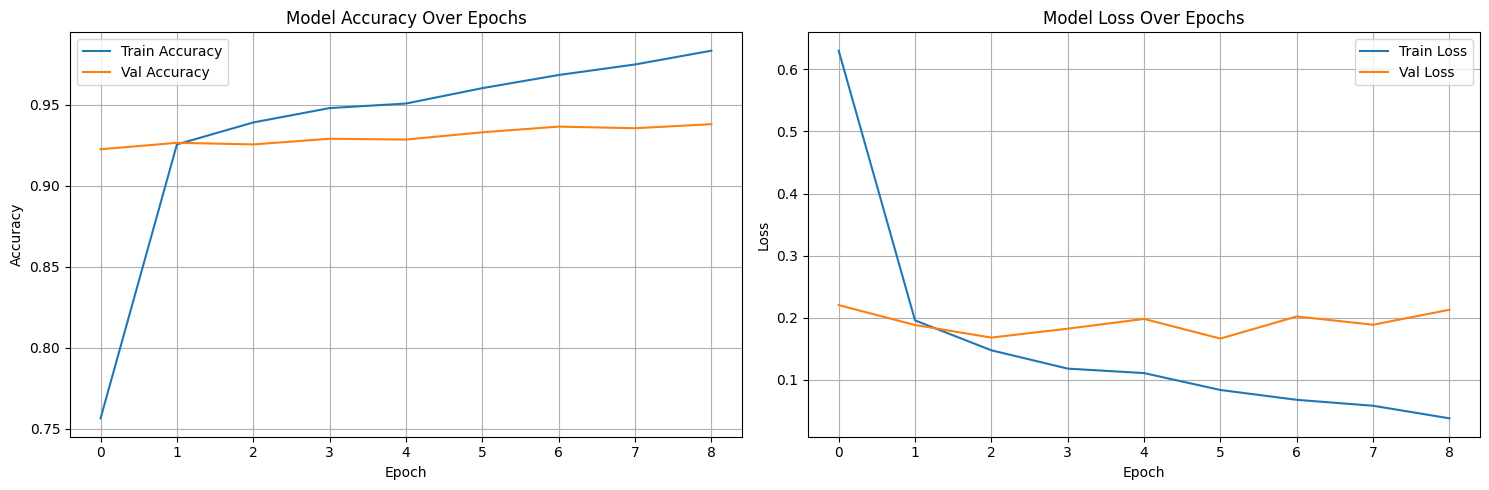

Final Training Accuracy: 0.9834
Final Validation Accuracy: 0.9380


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Over Epochs')
axes[0].legend()
axes[0].grid(True)

# Plot loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss Over Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

In [12]:
# Prepare test data
encoded_test = tokenize_text(list(df['test']['text']))
test_input_ids = encoded_test['input_ids']
test_attention_mask = encoded_test['attention_mask']
test_labels_list = list(df['test']['label'])

# Create test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(
    {"input_ids": test_input_ids, "attention_mask": test_attention_mask}
)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Get predictions
print("Making predictions on test set...")
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

print("Predictions completed!")


Making predictions on test set...
125/125 [==============================] - 6s 41ms/step
Predictions completed!


In [13]:
print("CLASSIFICATION REPORT")

emotion_labels = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']
report = classification_report(
    test_labels_list,
    predicted_labels,
    target_names=emotion_labels,
    digits=4
)
print(report)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Sadness     0.9875    0.9518    0.9693       581
         Joy     0.9844    0.9108    0.9462       695
        Love     0.7427    0.9623    0.8384       159
       Anger     0.9088    0.9418    0.9250       275
        Fear     0.9259    0.8929    0.9091       224
    Surprise     0.6889    0.9394    0.7949        66

    accuracy                         0.9300      2000
   macro avg     0.8730    0.9332    0.8971      2000
weighted avg     0.9394    0.9300    0.9323      2000



In [14]:
# Calculate overall metrics
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(test_labels_list, predicted_labels)
macro_f1 = f1_score(test_labels_list, predicted_labels, average='macro')
weighted_f1 = f1_score(test_labels_list, predicted_labels, average='weighted')

print("\n" + "="*60)
print("OVERALL METRICS")
print("="*60)
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")



OVERALL METRICS
Test Accuracy: 0.9300 (93.00%)
Macro F1-Score: 0.8971
Weighted F1-Score: 0.9323


In [15]:
import os

# Create model directory if it doesn't exist
os.makedirs('model', exist_ok=True)

# Save model weights
model_path = 'model/distilbert_emotion_classifier_improved.h5'
model.save_weights(model_path)

print(f"Model saved successfully to: {model_path}")
print("\nTraining and evaluation complete!")
print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")

Model saved successfully to: model/distilbert_emotion_classifier_improved.h5

Training and evaluation complete!

Final Test Accuracy: 93.00%
